In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

### Setup - Preprocessed Data 
randomly split dataset into train and test set <br>
by using `pandas` and `sklearn.model_selection`

In [2]:
data = pd.read_csv("winequalityred.csv", sep=";")
y = ["quality"]
x = data.drop(y, axis=1).columns.values

print("features: ", x)
print("target: ", y)
print("data shape: ", data.shape)
data.head(3)

features:  ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol']
target:  ['quality']
data shape:  (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [3]:
kf = KFold(shuffle=True, n_splits=5)
for trainIdx, testIdx in kf.split(data):
    X_train, X_test = data[x].iloc[trainIdx], data[x].iloc[testIdx]
    y_train, y_test = data[y].iloc[trainIdx], data[y].iloc[testIdx]

In [4]:
print(X_train.shape, y_train.shape)
pd.concat([X_train.head(3), y_train.head(3)], axis=1)

(1280, 11) (1280, 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [49]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,8.347891,0.526215,0.273102,2.539297,0.087073,15.618359,46.216797,0.996789,3.308703,0.656242,10.399297
std,1.764916,0.179786,0.192899,1.410870,0.047067,10.195828,32.715349,0.001883,0.155400,0.171403,1.051184
min,4.700000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,7.000000,22.000000,0.995640,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,37.000000,0.996800,3.310000,0.620000,10.100000
75%,9.300000,0.635000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997860,3.400000,0.730000,11.025000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,278.000000,1.003690,4.010000,2.000000,14.900000


In [5]:
print(X_test.shape, y_test.shape)
pd.concat([X_test.head(3), y_test.head(3)], axis=1)

(319, 11) (319, 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
15,8.9,0.62,0.19,3.9,0.170,51.0,148.0,0.9986,3.17,0.93,9.2,5


### Regression equations and functions
1. adding intercept
2. the equation for a the linear model that predicts y from X
3. the equation for computing the Residual Sum of Squares (RSS) for the linear model

by using `pandas` and `numpy`

In [6]:
def predict(beta, X):
    if isinstance(beta, (pd.DataFrame, pd.Series)):
        beta = beta.values
    
    if isinstance(X, (pd.DataFrame, pd.Series)):
        index = X.index.values
        X = X.values
    
    if beta.shape[0] - X.shape[1] == 1:
        X = np.concatenate([np.ones(shape=(X.shape[0], 1)), X], axis=1)
    
    return pd.DataFrame(np.matmul(X, beta), index=index, columns=["y_hat"])


def RSS(beta, X, y):
    tmp = pd.concat([y, predict(beta, X)], axis=1)
    
    if pd.isnull(tmp).any(axis=1).sum():
        raise ValueError("y and y_hat indexes are mismatched")
        
    return tmp.apply(lambda s: (s[0] - s[1])**2, axis=1).sum()

### Training Models
by using `pandas` and `scipy.optimize`

In [7]:
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train))
beta_hat = opt.x

In [8]:
beta_hat

array([ 7.60570425e+00,  9.41295298e-03, -1.06146954e+00, -1.08356100e-01,
        1.35100440e-02, -1.85721973e+00,  4.42476267e-03, -3.62921351e-03,
       -3.37437111e+00, -4.02207944e-01,  8.86551736e-01,  2.76109017e-01])

In [9]:
RSS(beta_hat, X_train, y_train)

536.6400931179439

### Question 1

What are the qualitative results from your model? <br>
Which features seem to be most important? <br>
Do you think that the magnitude of the features in X may affect the results <br>
(for example, the average total sulfur dioxide across all wines is 46.47, <br>
 but the average chlorides is only 0.087).

##### Ans:
1. my qualitative results show that density is the most significant feature, which has a negative relation with wine quality(y)
2. density (with coefficient: -3.374)
3. no, the scatters plot (density vs quality and sulphates vs quality) show that scale does not affect the results

In [11]:
pd.Series(beta_hat, index=["intercept"] + X_train.columns.values.tolist())\
    .round(3)\
    .sort_values()

density                -3.374
chlorides              -1.857
volatile acidity       -1.061
pH                     -0.402
citric acid            -0.108
total sulfur dioxide   -0.004
free sulfur dioxide     0.004
fixed acidity           0.009
residual sugar          0.014
alcohol                 0.276
sulphates               0.887
intercept               7.606
dtype: float64

<BarContainer object of 11 artists>

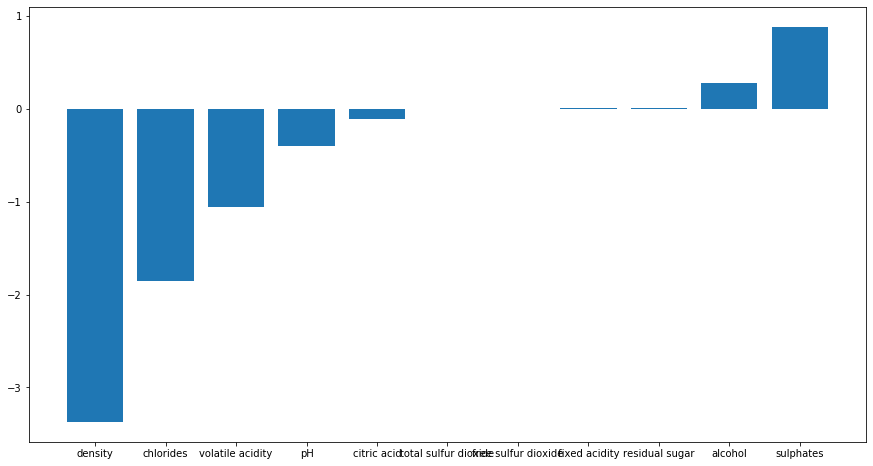

In [12]:
plt.figure(figsize=(15, 8))
plt.bar(X_train.columns[np.argsort(beta_hat[1:])], np.sort(beta_hat[1:]), align="center")

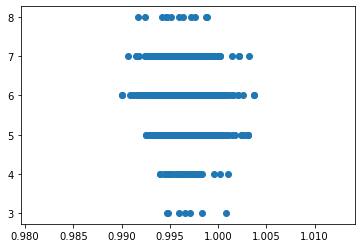

In [13]:
plt.scatter(X_train["density"], y_train)

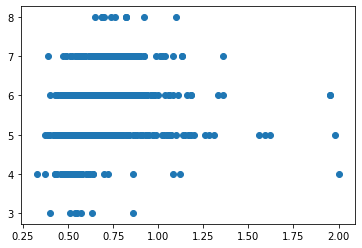

In [14]:
plt.scatter(X_train["sulphates"], y_train)

How well does your model fit? <br>
You should be able to measure the goodness of fit, RSS, <br>
on both the training data and the test data, <br>
but only report the results on the test data. <br>
<br>
In Machine Learning we almost always only care about<br> 
how well the model fits on data that has not been used to fit the model, <br>
because we need to use the model in the future, not the past. <br>
Therefore, we only report performance with holdout data, or test data.

In [15]:
def r_square(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("length mismatched")
    
    tmp = pd.concat([y_true, y_pred], axis=1)
    tmp.columns = ["y_true", "y_pred"]
    ss_res = sum((tmp["y_true"] - tmp["y_pred"])**2)
    ss_tot = sum((tmp["y_true"] - tmp["y_true"].mean())**2)
    return 1 - ss_res/ss_tot

In [16]:
print("Model Performance in the Test Set: ")
print("RSS: ", RSS(beta_hat, X_test, y_test))
print("R^2(Goodness of Fit): ", r_square(y_test, predict(beta_hat, X_test)))

Model Performance in the Test Set: 
RSS:  130.5263193301833
R^2(Goodness of Fit):  0.3988001982972622


Does the end result or RSS change if you try different initial values of β? <br>
What happens if you change the magnitude of the initial β?

##### Ans
it does not change a lot when we try different init value, the magnitude of beta, or the solver. 

it always trains similar model.

In [17]:
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))
print("new init beta: ", beta.reshape(1, -1)[0], "\n")
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train))
new_beta_hat = opt.x
print("the diff between new beta hat and beta hat", new_beta_hat - beta_hat, "\n")
print("new RSS: ", RSS(new_beta_hat, X_train, y_train))

new init beta:  [ 1.62880756  1.43991777  0.43556328  1.96811993  1.41434108  1.66287419
  0.74711356  0.18859671  1.30126725 -0.12910841  0.3768061   0.9917199 ] 

the diff between new beta hat and beta hat [ 1.36094218e-03  1.34216577e-06  9.50960573e-07 -2.80882229e-08
  5.65101470e-07  4.81611258e-06 -1.08039449e-08  5.98083859e-09
 -1.39171815e-03  7.33198888e-06  1.60894508e-06 -1.21575442e-06] 

new RSS:  536.6400931153305


In [20]:
beta = np.random.normal(100, 10, (X_train.shape[1] + 1, 1))
print("new init beta: ", beta.reshape(1, -1)[0], "\n")
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train))
new_beta_hat = opt.x
print("the diff between new beta hat and beta hat", new_beta_hat - beta_hat, "\n")
print("new RSS: ", RSS(new_beta_hat, X_train, y_train))

new init beta:  [ 95.59918673 100.81331956  95.61484705  91.92144924  98.83694237
  96.98986182  99.18809076 101.11523189 114.3765332   95.76297988
 103.7151592  112.24766032] 

the diff between new beta hat and beta hat [-4.19882595e-05 -3.46821936e-08 -4.02260585e-08  1.43666954e-07
 -1.93301446e-08  1.14095589e-07  9.55724996e-11  5.71235863e-10
  4.20803923e-05  3.23687117e-08 -1.14790813e-07  3.13652069e-08] 

new RSS:  536.6400931179884


Does the choice of solver method change the end result or RSS? 

In [19]:
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))
print("new init beta: ", beta.reshape(1, -1)[0], "\n")
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train), method="Powell")
new_beta_hat = opt.x
print("the diff between new beta hat and beta hat", new_beta_hat - beta_hat, "\n")
print("new RSS: ", RSS(new_beta_hat, X_train, y_train))

new init beta:  [ 0.63304156 -0.78552402 -1.42122776  0.15914259 -1.77147449  0.69755715
  0.25193168  0.73105988  2.06135173 -0.06364885 -0.76269358  0.87897901] 

the diff between new beta hat and beta hat [-3.46551354e+01  1.55810283e-02 -7.92983274e-02  7.27581196e-02
 -1.38425013e-02  3.19783107e-01 -1.28223133e-03  5.91919880e-04
  3.20413611e+01  7.55839688e-01  8.06167843e-04  1.00107909e-02] 

new RSS:  548.9636251862221


### Question 2

In [21]:
def RSS(beta, X, y, penalty=None, lam=0.01):
    tmp = pd.concat([y, predict(beta, X)], axis=1)
    
    if pd.isnull(tmp).any(axis=1).sum():
        raise ValueError("y and y_hat indexes are mismatched")
        
        
    if penalty == "l1":
        penalty = lam * sum(abs(beta[1:])
                           )
    elif penalty == "l2":
        penalty = lam * sum(beta[1:]**2)
        
    else:
        penalty = 0
        
    return tmp.apply(lambda s: (s[0] - s[1])**2, axis=1).sum() + penalty

##### Ridge Regression (L2)

In [22]:
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2"))
beta_hat_L2 = opt.x

In [36]:
pd.DataFrame(
    np.array([beta_hat, beta_hat_L2]).T, 
    index=["intercept"] + X_train.columns.values.tolist(),
    columns=["beta_hat", "beta_hat_L2"]
).round(3)

,beta_hat,beta_hat_L2
intercept,7.606,4.524
fixed acidity,0.009,0.007
volatile acidity,-1.061,-1.064
citric acid,-0.108,-0.109
residual sugar,0.014,0.012
chlorides,-1.857,-1.853
free sulfur dioxide,0.004,0.004
total sulfur dioxide,-0.004,-0.004
density,-3.374,-0.233
pH,-0.402,-0.417


How does RSS on the training data change? How does RSS on the test data change?

### Ans
both RSS in train and test set are slightly raised. this is probably because there is no overfitting issue in the original regression. Hence, a complex model (original model) outperforms a simple model (ridge regression).

In [39]:
print("Ridge Regression Performance")
print("RSS in train set: ", RSS(beta_hat_L2, X_train, y_train))
print("RSS in test set: ", RSS(beta_hat_L2, X_test, y_test))

Ridge Regression Performance
RSS in train set:  536.6474353611491
RSS in test set:  130.62036314242602


In [46]:
print("Ridge Regression RSS in test set")
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))

lam = 0.001
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 0.01
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 0.1
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 1
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 10
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l2", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

Ridge Regression RSS in test set
when lambda=0.001 130.58210197450867
when lambda=0.010 130.6203553576877
when lambda=0.100 130.6670163002344
when lambda=1.000 131.14401739219915
when lambda=10.000 134.05128161657322


### Ans
the results above prove my speculation that there is no overfitting issue. Since the larger lambda returns worse RSS, this represents no need to regularize. 

##### Lasso Regression (L1)

In [47]:
print("Lasso Regression RSS in test set")
beta = np.random.normal(0, 1, (X_train.shape[1] + 1, 1))

lam = 0.001
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 0.01
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 0.1
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 1
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

lam = 10
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))

Lasso Regression RSS in test set
when lambda=0.001 130.54585859200915
when lambda=0.010 130.62591325138112
when lambda=0.100 130.74851857578417
when lambda=1.000 130.98671403233485
when lambda=10.000 134.93298489810562


In [58]:
lam = 0.01
opt = minimize(fun=RSS, x0=beta, args=(X_train, y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, X_test, y_test))
pd.Series(opt.x[1:], index=X_test.columns.values)

when lambda=0.010 130.62591325138112


fixed acidity           6.288149e-03
volatile acidity       -1.064010e+00
citric acid            -1.083022e-01
residual sugar          1.211711e-02
chlorides              -1.859654e+00
free sulfur dioxide     4.447296e-03
total sulfur dioxide   -3.639038e-03
density                -7.934891e-09
pH                     -4.181624e-01
sulphates               8.815723e-01
alcohol                 2.791723e-01
dtype: float64

In [59]:
# normalized X_train
from sklearn.preprocessing import Normalizer

lam = 0.01
norm = Normalizer()
norm.fit(X_train)
def normal(X):
    return pd.DataFrame(norm.transform(X), columns=X.columns.values, index=X.index.values)

opt = minimize(fun=RSS, x0=beta, args=(normal(X_train), y_train, "l1", lam))
print("when lambda=%.3f" % lam, RSS(opt.x, normal(X_test), y_test))
pd.Series(opt.x[1:], index=X_test.columns.values)

when lambda=0.010 134.76822560186184


fixed acidity            1.277278
volatile acidity       -33.123443
citric acid            -11.043585
residual sugar           0.789888
chlorides              -45.244510
free sulfur dioxide      1.586855
total sulfur dioxide     2.406756
density                -27.825176
pH                     -20.887220
sulphates               39.819290
alcohol                 10.236965
dtype: float64

##### Ans
the magnitude of the features in X won't affect the results with regularization. But, the magnitude of the coefficient will be affect by regularization. The less information a larger